In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler, MinMaxScaler # for normalization
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

## for Deep-learning
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
import itertools

In [2]:
DATASET_PATH = os.getcwd() + '/dataset/'

df = pd.read_csv(DATASET_PATH + 'household_power_consumption.csv', 
                parse_dates = True, index_col = 'datetime', low_memory = False)

print(df.shape)
## resampling of data over day
df_resampled_day = df.resample('D').sum()
print(df_resampled_day.shape)
## resampling of data over hour
df_resampled_hour = df.resample('h').mean()
print(df_resampled_hour.shape)

(2075259, 7)
(1442, 7)
(34589, 7)


In [3]:
df_resampled_hour.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [4]:
df_resampled_hour.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000
2010-11-26 20:00:00,1.163700,0.061167,239.396000,4.913333,0.0,1.066667,0.000000
2010-11-26 21:00:00,0.934667,0.000000,239.690000,3.800000,0.0,0.000000,0.000000


## Normalization/Scaling
* Scale all features in range of [0,1]

In [5]:
# get values
values = df_resampled_hour.values 
values

array([[4.22288889e+00, 2.29000000e-01, 2.34643889e+02, ...,
        0.00000000e+00, 5.27777778e-01, 1.68611111e+01],
       [3.63220000e+00, 8.00333333e-02, 2.34580167e+02, ...,
        0.00000000e+00, 6.71666667e+00, 1.68666667e+01],
       [3.40023333e+00, 8.52333333e-02, 2.33232500e+02, ...,
        0.00000000e+00, 1.43333333e+00, 1.66833333e+01],
       ...,
       [1.65933333e+00, 6.00333333e-02, 2.36741000e+02, ...,
        0.00000000e+00, 6.66666667e-02, 0.00000000e+00],
       [1.16370000e+00, 6.11666667e-02, 2.39396000e+02, ...,
        0.00000000e+00, 1.06666667e+00, 0.00000000e+00],
       [9.34666667e-01, 0.00000000e+00, 2.39690000e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# lets see
scaled

array([[0.63681623, 0.29573827, 0.33794529, ..., 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, ..., 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, ..., 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, ..., 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, ..., 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, ..., 0.        , 0.        ,
        0.        ]])

## Reframing
* Reframe timeseries as supervised 

In [7]:
"""
Function to reframe time series to a supervised
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
df_resampled_hour.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [9]:
df_reframed = series_to_supervised(scaled, 1, 1)
# lets see
df_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723


In [10]:
# drop unneeded column
df_reframed.drop(df_reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
# lets see
df_reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418,0.545045
2,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.509006
3,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.488550
4,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.455597
5,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.322555


## Split Dataset and Reshape
* Split dataset  
    * Train (first 1 year)
    * Test (3 years later)
* Reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features]

In [11]:
# split into train and test sets
values = df_reframed.values

n_train_time = 365 * 24 # 1 tahun
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and output (global active power prediction)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [12]:
pd.DataFrame(train_X).head()

,0,1,2,3,4,5,6
0,0.636816,0.295738,0.337945,0.631157,0.0,0.011366,0.782418
1,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676
2,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169
3,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809
4,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917


In [13]:
pd.DataFrame(train_y).head()

,0
0,0.545045
1,0.509006
2,0.488550
3,0.455597
4,0.322555


In [14]:
pd.DataFrame(test_X).head()

,0,1,2,3,4,5,6
0,0.365254,0.084589,0.478316,0.353419,0.000000,0.008973,0.808971
1,0.388817,0.054843,0.453106,0.376255,0.000000,0.000000,0.804331
2,0.421065,0.278046,0.471526,0.410569,0.000000,0.008615,0.807425
3,0.566014,0.090142,0.485451,0.549259,0.160924,0.000000,0.810518
4,0.347584,0.118855,0.643803,0.331420,0.183666,0.007897,0.497293


In [15]:
pd.DataFrame(test_y).head()

,0
0,0.388817
1,0.421065
2,0.566014
3,0.347584
4,0.045159


In [16]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


## Build Model
1. LSTM with 100 neurons in the first visible layer
3. dropout 20%
4. 1 neuron in the output layer for predicting Global_active_power.
5. The input shape will be 1 time step with 7 features.
6. I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
7. The model will be fit for 20 training epochs with a batch size of 70.

W1203 10:26:37.867973 4612085184 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 8760 samples, validate on 25828 samples


W1203 10:26:38.968089 4612085184 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
8760/8760 - 3s - loss: 0.0197 - val_loss: 0.0118
Epoch 2/20
8760/8760 - 2s - loss: 0.0124 - val_loss: 0.0105
Epoch 3/20
8760/8760 - 1s - loss: 0.0114 - val_loss: 0.0097
Epoch 4/20
8760/8760 - 1s - loss: 0.0109 - val_loss: 0.0094
Epoch 5/20
8760/8760 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 6/20
8760/8760 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 7/20
8760/8760 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 8/20
8760/8760 - 1s - loss: 0.0106 - val_loss: 0.0094
Epoch 9/20
8760/8760 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 10/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 11/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 12/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 13/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 14/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 15/20
8760/8760 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 16/20
8760/8760 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 17/20
8760/8760 - 1s - loss

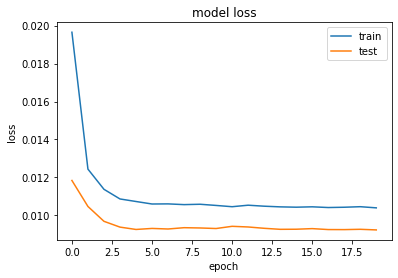

Test RMSE: 0.619


In [17]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(None,train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
"""model.add(LSTM(70,return_sequences=True))
model.add(Dropout(0.3))"""
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               43200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


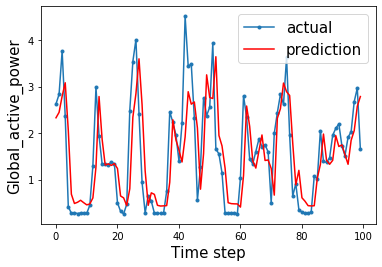

In [21]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

hour = 100

aa = [x for x in range(hour)]
plt.plot(aa, inv_y[:hour], marker='.', label="actual")
plt.plot(aa, inv_yhat[:hour], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()